# RANDOM FOREST MODEL BUILD

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Preprocessed Train & Test Datasets

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Set dataset directory path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/"

# Load preprocessed train and test sets
train_df = pd.read_csv(dataset_path + "train.csv")
test_df = pd.read_csv(dataset_path + "test.csv")

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)


Train dataset shape: (1515164, 16)
Test dataset shape: (726426, 16)


# Separate Features and Labels

In [3]:
print("Train Columns:", train_df.columns.tolist())
print("Test Columns:", test_df.columns.tolist())

Train Columns: ['Total Length of Bwd Packets', 'Packet Length Std', 'Subflow Bwd Bytes', 'Fwd Packet Length Max', 'Bwd Packet Length Max', 'Total Length of Fwd Packets', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Variance', 'Init_Win_bytes_backward', 'Init_Win_bytes_forward', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Average Packet Size', 'Label']
Test Columns: ['Total Length of Bwd Packets', 'Packet Length Std', 'Subflow Bwd Bytes', 'Fwd Packet Length Max', 'Bwd Packet Length Max', 'Total Length of Fwd Packets', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Variance', 'Init_Win_bytes_backward', 'Init_Win_bytes_forward', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Average Packet Size', 'Label']


In [4]:
# Identify feature columns (all except label columns)
label_column = 'Label'
feature_columns = [col for col in train_df.columns if col != label_column]

# Extract features (X) and labels (y)
X_train, y_train = train_df[feature_columns], train_df[label_column]
X_test, y_test = test_df[feature_columns], test_df[label_column]

# Encode labels into integer categories
y_train, label_encoder = pd.factorize(y_train)
y_test = label_encoder.get_indexer(y_test)

print(f"Feature columns: {len(feature_columns)}, Label classes: {len(label_encoder)}")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Feature columns: 15, Label classes: 13
Training samples: 1515164, Testing samples: 726426


# Define and Train the Random Forest Model

In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

clf = RandomForestClassifier(
    max_depth=15,
    n_estimators=500,
    min_samples_split=2,
    class_weight=weights_dict,
    n_jobs=-1,
    random_state=42
)

# Start training timer
start = time.time()
clf.fit(X_train, y_train)
end = time.time()

print(f'Elapsed Training Time: {(end - start)/60:.2f} minutes')

Elapsed Training Time: 4.09 minutes


In [23]:
print("Number of Features Used:", X_train.shape[1])

Number of Features Used: 15


# Perform Predictions

In [24]:
# Start prediction timer
start = time.time()
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)  # Probability scores for AUC-ROC
end = time.time()

print(f'Elapsed Prediction Time: {(end - start)/60:.2f} minutes')

Elapsed Prediction Time: 0.29 minutes


# Generate Confusion Matrix

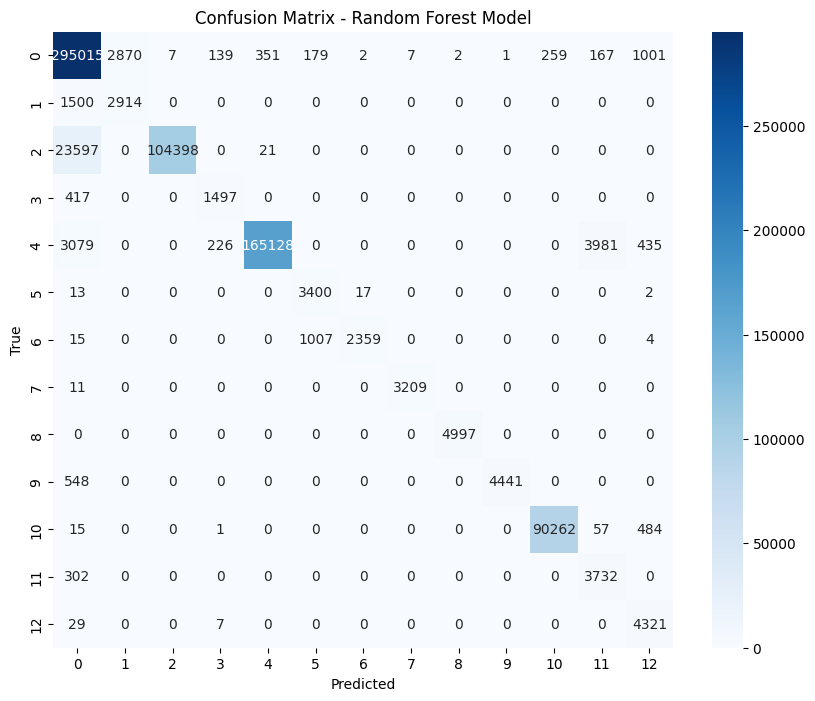


Classification Report:
                  precision    recall  f1-score   support

          BENIGN       0.91      0.98      0.94    300000
             Bot       0.50      0.66      0.57      4414
            DDoS       1.00      0.82      0.90    128016
   DoS GoldenEye       0.80      0.78      0.79      1914
        DoS Hulk       1.00      0.96      0.98    172849
DoS Slowhttptest       0.74      0.99      0.85      3432
   DoS slowloris       0.99      0.70      0.82      3385
     FTP-Patator       1.00      1.00      1.00      3220
      Heartbleed       1.00      1.00      1.00      4997
    Infiltration       1.00      0.89      0.94      4989
        PortScan       1.00      0.99      1.00     90819
     SSH-Patator       0.47      0.93      0.62      4034
      Web Attack       0.69      0.99      0.81      4357

        accuracy                           0.94    726426
       macro avg       0.85      0.90      0.86    726426
    weighted avg       0.95      0.94      0.9

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix correctly
conf_matrix = confusion_matrix(y_test, y_pred)

# Ensure all values are positive
conf_matrix = np.abs(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest Model')
plt.show()

import joblib
from sklearn.metrics import classification_report

# ✅ Load the saved LabelEncoder
encoder_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/label_encoder.pkl"
label_encoder = joblib.load(encoder_path)

# ✅ Convert class labels to strings
class_names = [str(cls) for cls in label_encoder.classes_]

# ✅ Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))




In [26]:
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in y_pred: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


# Compute Performance Metrics

In [27]:
# Define metric functions
def ACC(TP,TN,FP,FN):
    return (TP+TN)/(TP+FP+FN+TN)

def PRECISION(TP,FP):
    return TP/(TP+FP)

def RECALL(TP,FN):
    return TP/(TP+FN)

def F1(Recall, Precision):
    return 2 * Recall * Precision / (Recall + Precision)

def BACC(TP,TN,FP,FN):
    return (TP/(TP+FN) + TN/(TN+FP)) * 0.5

def MCC(TP,TN,FP,FN):
    TP = np.array(TP, dtype=np.float64)
    TN = np.array(TN, dtype=np.float64)
    FP = np.array(FP, dtype=np.float64)
    FN = np.array(FN, dtype=np.float64)

    numerator = (TN * TP - FN * FP)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Handle division by zero
    if denominator == 0:
        return 0

    return numerator / denominator

# Calculate True Positives (TP), False Positives (FP), False Negatives (FN), and True Negatives (TN)
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (FP + FN + TP)

# Compute Metrics
Acc = ACC(sum(TP), sum(TN), sum(FP), sum(FN))
Precision = PRECISION(sum(TP), sum(FP))
Recall = RECALL(sum(TP), sum(FN))
F1_score = F1(Recall, Precision)
BACC_score = BACC(sum(TP), sum(TN), sum(FP), sum(FN))
MCC_score = MCC(sum(TP), sum(TN), sum(FP), sum(FN))

# Print Performance Metrics
print(f'Accuracy: {Acc:.4f}')
print(f'Precision: {Precision:.4f}')
print(f'Recall: {Recall:.4f}')
print(f'F1 Score: {F1_score:.4f}')
print(f'BACC: {BACC_score:.4f}')
print(f'MCC: {MCC_score:.4f}')

Accuracy: 0.9914
Precision: 0.9439
Recall: 0.9439
F1 Score: 0.9439
BACC: 0.9696
MCC: 0.9392


# Compute AUC-ROC Score

In [28]:
n_classes = len(label_encoder.classes_)  # Number of output classes

# Compute ROC-AUC for multi-class classification
auc_score = roc_auc_score(label_binarize(y_test, classes=range(n_classes)), y_pred_proba, multi_class='ovr')
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9983


# Save the Trained Random Forest Model

In [29]:
import joblib

model_folder = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_RandomForest.joblib"
model_path = model_folder + model_filename

joblib.dump(clf, model_path)
print(f"Random Forest model saved to: {model_path}")


Random Forest model saved to: /content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/CICIDS-2017_RandomForest.joblib
